In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns
import anndata

from scroutines import basicu
from scroutines.config_plots import *
import importlib
importlib.reload(basicu)

<module 'scroutines.basicu' from '/u/project/zipursky/f7xiesnm/code/scroutines/scroutines/basicu.py'>

In [2]:
def show_onetype(idx, columns=["NR_1", "NR_2", "NR_3", "NR_4", 
                               "DR_1", "DR_2", "DR_3", "DR_4",
                              ]):
    """idx - cell type idx
    """
    gidx = np.logical_or(sde_up[:,idx], sde_dn[:,idx])
    _genes = genes_comm[gidx]

    p_nr = tensor_nr[gidx,:,:][:,idx,:]
    p_dr = tensor_dr[gidx,:,:][:,idx,:]
    
    
    ab = np.hstack([p_nr, p_dr])
    nr_mean = np.mean(p_nr, axis=1)
    ab = (ab - nr_mean.reshape(-1,1))*np.log2(10) # log2 FC w.r.t. the mean in NR
    ab = pd.DataFrame(ab, index=_genes, columns=columns)
    
    this_mlfc = (np.mean(p_nr, axis=1) - np.mean(p_dr, axis=1))*np.log2(10)
    this_ordr = np.argsort(this_mlfc)
    ab = ab.iloc[this_ordr]
    
    fig, ax = plt.subplots(figsize=(4, min(10, 0.3*len(ab))))
    sns.heatmap(ab, center=0, cmap='coolwarm', yticklabels=True, cbar_kws=dict(shrink=0.5, label='log2 FC (w.r.t. NR mean)'))
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(unq_types[idx])
    plt.show()

In [3]:
def show_volcano(thetypeidx, thetype, lfc, qs, cond1, cond2up, cond2dn, ax=None, bbox_to_anchor=(1,1), loc=None):
    """
    """
    eff = lfc[:,thetypeidx]
    pvl =  qs[:,thetypeidx]

    cnd_up = np.all([cond1[:,thetypeidx], 
                     cond2up[:,thetypeidx]], axis=0) 
    cnd_dn = np.all([cond1[:,thetypeidx], 
                     cond2dn[:,thetypeidx]], axis=0) 

    if ax is None:
        fig, ax = plt.subplots()
    else:
        pass
    ax.scatter(eff, -np.log10(pvl), s=1, color='gray')

    ax.scatter(eff[cnd_up], -np.log10(pvl)[cnd_up], s=5, #s=5, 
               label=f'DR up (n={cnd_up.sum():,})')
    ax.scatter(eff[cnd_dn], -np.log10(pvl)[cnd_dn], s=5, #s=5, 
               label=f'DR dn (n={cnd_dn.sum():,})')

    ax.set_xlabel('log2(FC) (DR/NR in CPM)')
    ax.set_ylabel('-log10(FDR)')
    ax.set_title(f'{thetype}')
    ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc)
    return ax

In [4]:
sns.set_context('talk')

In [5]:
outdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results"
outdir

'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results'

# get data

In [6]:
# get updated cell types
f = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/allL23_newtypes.csv"
meta = pd.read_csv(f, index_col=0)
meta

/tmp/ipykernel_26078/12491127.py:3: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(f, index_col=0)


,Class_broad,Doublet,Doublet Score,batch,leiden,n_counts,n_genes,percent_mito,sample,Type,Subclass,cond,easitype,umap1,umap2,easisample,easicond,newtype
AAACGCTCACTTCATT-1-P8_1a-P8,Excitatory,False,0.025713,1,0,23384.0,4943,0.000128,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGGATAGGTGCATG-1-P8_1a-P8,Excitatory,False,0.011883,1,0,17774.0,4698,0.000169,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGGGCCAGTATACC-1-P8_1a-P8,Excitatory,False,0.024667,1,0,15872.0,4173,0.000126,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGTCCCATATACCG-1-P8_1a-P8,Excitatory,False,0.027921,1,0,20076.0,4761,0.000050,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGTCCTCAGATGCT-1-P8_1a-P8,Excitatory,False,0.009527,1,4,19061.0,4601,0.000000,P8_1a,L2/3_BC,L2/3,P8NR,L2/3_C,NaN,NaN,1a,1-P08NR,L2/3_C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCAGTTGTTG-1-P38_dr_1a,NaN,False,0.042872,11,1,11379.0,3568,0.000879,P38_dr_1a,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,1a,2-P38DR,L2/3_B
TTTGGTTTCTGCCTGT-1-P38_dr_2b,NaN,False,0.007108,2,1,16050.0,3104,0.000062,P38_dr_2b,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,2b,2-P38DR,L2/3_B
TTTGTTGCACCGGTCA-1-P38_dr_2a,NaN,False,0.030928,2,1,13955.0,3739,0.001146,P38_dr_2a,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,2a,2-P38DR,L2/3_B
TTTGTTGGTGGCTAGA-1-P38_dr_2b,NaN,False,0.015884,3,4,7272.0,2789,0.000963,P38_dr_2b,L2/3_2,L2/3,P38DR,L2/3_B,NaN,NaN,2b,2-P38DR,L2/3_A


In [7]:
ddir = '../../data/cheng21_cell_scrna/organized/'
files = [
    'P28NR.h5ad',
    'P38NR.h5ad',
    
    'P28DR.h5ad',
    'P38DR.h5ad',
] 

In [8]:
pbulks = []
xclsts = []
xcnsts = []

ncond, nrep, nclst, ngene = 4,2,20, -1, #42-3,-1 # remove 3 L4 types

for f in files:
    print(f)
    
    path = os.path.join(ddir, f)
    adata = anndata.read(path)
    genes = adata.var.index.values
    
    tmp = adata.obs.copy()
    # labels - by sample and type 
    # 1 or 2
    sample_codes = tmp['sample'].apply(lambda x: x.split('_')[-1][:-1].replace('3', '2')).astype(str).values
    tmp['sample_code'] = sample_codes
    
    types = tmp['Subclass'].astype(str).values
    
    sample_and_type = sample_codes + "_" + types
    tmp['sample_and_type'] = sample_and_type
    
    # sample 
    n = 200
    cat_filter = tmp.groupby('sample_and_type').size() > n
    tmp = tmp[tmp['sample_and_type'].isin(cat_filter[cat_filter].index.values)]
    
    tmp = tmp.groupby('sample_and_type').apply(lambda x: x.sample(n, replace=False))
    cells = tmp.index.get_level_values(level=1)
    adata = adata[cells]
    
    # update 
    tmp = adata.obs.copy()
    # 1 or 2
    sample_codes = tmp['sample'].apply(lambda x: x.split('_')[-1][:-1].replace('3', '2')).astype(str).values
    tmp['sample_code'] = sample_codes
    
    types = tmp['Subclass'].astype(str).values
    
    sample_and_type = sample_codes + "_" + types
    tmp['sample_and_type'] = sample_and_type
    
    # group data
    _xclsts, Xk, Xk_n, Xk_ln = basicu.counts_to_bulk_profiles(adata.X, sample_and_type) 
        
    unqs, cnts = np.unique(sample_and_type, return_counts=True)
    
    pbulks.append(Xk_ln)
    xclsts.append(_xclsts)
    xcnsts.append(cnts)
    

P28NR.h5ad
P38NR.h5ad
P28DR.h5ad
P38DR.h5ad


In [9]:
for a, b, c in zip(pbulks, xclsts, xcnsts):
    print(a.shape, b.shape, c.shape)

# use the same types
xclsts_comm = xclsts[0]
for a in xclsts[1:]:
    xclsts_comm = np.intersect1d(xclsts_comm, a)
    print(xclsts_comm.shape)
print(xclsts_comm.shape)

# has to appear twice
unq, inv, cnts = np.unique([clst.split('_')[1] for clst in xclsts_comm], return_inverse=True, return_counts=True)
typelist = unq[cnts==2]
xclsts_comm = np.sort([i for i in xclsts_comm if i.split('_')[1] in typelist])

# check 
tmp = xclsts_comm.reshape(2,-1)
print(tmp)


# trim 
pbulks_trim = []
xclsts_trim = []
xcnsts_trim = []
for a, b, c in zip(pbulks, xclsts, xcnsts):
    b_idx = basicu.get_index_from_array(b, xclsts_comm)
    ap = a[b_idx]
    bp = b[b_idx]
    cp = c[b_idx]
    pbulks_trim.append(ap)
    xclsts_trim.append(bp)
    xcnsts_trim.append(cp)

pbulks = pbulks_trim
xclsts = xclsts_trim
xcnsts = xcnsts_trim
for a, b, c in zip(pbulks, xclsts, xcnsts):
    print(a.shape, b.shape, c.shape)

(26, 53801) (26,) (26,)
(21, 53801) (21,) (21,)
(27, 53801) (27,) (27,)
(25, 53801) (25,) (25,)
(20,)
(20,)
(18,)
(18,)
[['1_Astro' '1_L2/3' '1_L4' '1_L6CT' '1_L6IT' '1_OD']
 ['2_Astro' '2_L2/3' '2_L4' '2_L6CT' '2_L6IT' '2_OD']]
(12, 53801) (12,) (12,)
(12, 53801) (12,) (12,)
(12, 53801) (12,) (12,)
(12, 53801) (12,) (12,)


In [10]:
nclst = int(len(xclsts_comm)/2)

In [11]:
pbulks = np.array(pbulks)
xcnsts = np.array(xcnsts)
xclsts = np.array(xclsts)
print(pbulks.shape)
print(xcnsts.shape)
print(xclsts.shape)

pbulks = pbulks.reshape(ncond,nrep,nclst,-1)
xcnsts = xcnsts.reshape(ncond,nrep,nclst)
xclsts = xclsts.reshape(ncond,nrep,nclst)
print(pbulks.shape)
print(xcnsts.shape)
print(xclsts.shape)

(4, 12, 53801)
(4, 12)
(4, 12)
(4, 2, 6, 53801)
(4, 2, 6)
(4, 2, 6)


In [12]:
pbulks = pbulks.reshape(2,4,pbulks.shape[2], pbulks.shape[3])
print(pbulks.shape)

(2, 4, 6, 53801)


In [13]:
# check the pbulks are good -- log10(CPM+1) for each sample
checkpbulks = np.sum(np.power(10, pbulks)-1, axis=-1)
checkpbulks.shape, np.all(np.abs(checkpbulks-1e6) < 1e-6)

((2, 4, 6), True)

In [14]:
# xclsts_short = np.array([clst[len("1a_"):] for clst in xclsts[0]]) #, '_'
xclsts_short = np.array([clst[len("1_"):] for clst in xclsts_comm.reshape(2,-1)[0]]) #, '_'
xclsts_short, xclsts_short.shape

(array(['Astro', 'L2/3', 'L4', 'L6CT', 'L6IT', 'OD'], dtype='<U5'), (6,))

In [15]:
numcells = pd.DataFrame(xcnsts.T.reshape(-1,nrep*ncond), index=xclsts_short)
numcells

,0,1,2,3,4,5,6,7
Astro,200,200,200,200,200,200,200,200
L2/3,200,200,200,200,200,200,200,200
L4,200,200,200,200,200,200,200,200
L6CT,200,200,200,200,200,200,200,200
L6IT,200,200,200,200,200,200,200,200
OD,200,200,200,200,200,200,200,200


In [16]:
tensor_nr = pbulks[0].T
tensor_dr = pbulks[1].T
print(tensor_nr.shape)
print(tensor_dr.shape)

# mean exp of CPM=10 in any subclass in either NR or DR
expressed_nr  = np.any(np.mean(tensor_nr, axis=2) > np.log10(10+1), axis=1) 
expressed_dr  = np.any(np.mean(tensor_dr, axis=2) > np.log10(10+1), axis=1) 
expressed_any = np.logical_or(expressed_nr, expressed_dr)

genes_comm = genes[expressed_any]
genes_cidx = np.arange(len(genes))[expressed_any] 
tensor_nr = pbulks[0].T[genes_cidx]
tensor_dr = pbulks[1].T[genes_cidx]

print(tensor_nr.shape)
print(tensor_dr.shape)

(53801, 6, 4)
(53801, 6, 4)
(11698, 6, 4)
(11698, 6, 4)


In [17]:
# test for each gene and cell type; 4 rep vs 4 rep - t-test and p-val correction 
ts, ps = ttest_ind(tensor_nr, tensor_dr, axis=2)
rs, qs, _, _ = multipletests(np.nan_to_num(ps, nan=1).reshape(-1,), method='fdr_bh')
rs = rs.reshape(ps.shape)
qs = qs.reshape(ps.shape)

# effect size
lfc = np.log2(10)*(np.mean(tensor_dr, axis=2) - np.mean(tensor_nr, axis=2)) # log2FC (log10CPM as raw counts)

In [18]:
fc_threshold = 2
cond1   = rs # FDR< 0.05
cond2   = np.abs(lfc) >  np.log2(fc_threshold) 
cond2up = lfc         >  np.log2(fc_threshold) 
cond2dn = lfc         < -np.log2(fc_threshold) 

sde    = np.all([cond1, cond2],   axis=0)
sde_up = np.all([cond1, cond2up], axis=0)
sde_dn = np.all([cond1, cond2dn], axis=0)

sigsum = pd.DataFrame(index=xclsts_short)
sigsum['rej']   = np.sum(rs, axis=0)
sigsum['DE']    = np.sum(sde, axis=0)
sigsum['DR_up'] = np.sum(sde_up, axis=0)
sigsum['DR_dn'] = np.sum(sde_dn, axis=0)
sigsum

,rej,DE,DR_up,DR_dn
Astro,8,7,7,0
L2/3,65,22,15,7
L4,20,2,1,1
L6CT,18,6,5,1
L6IT,36,11,11,0
OD,1,0,0,0


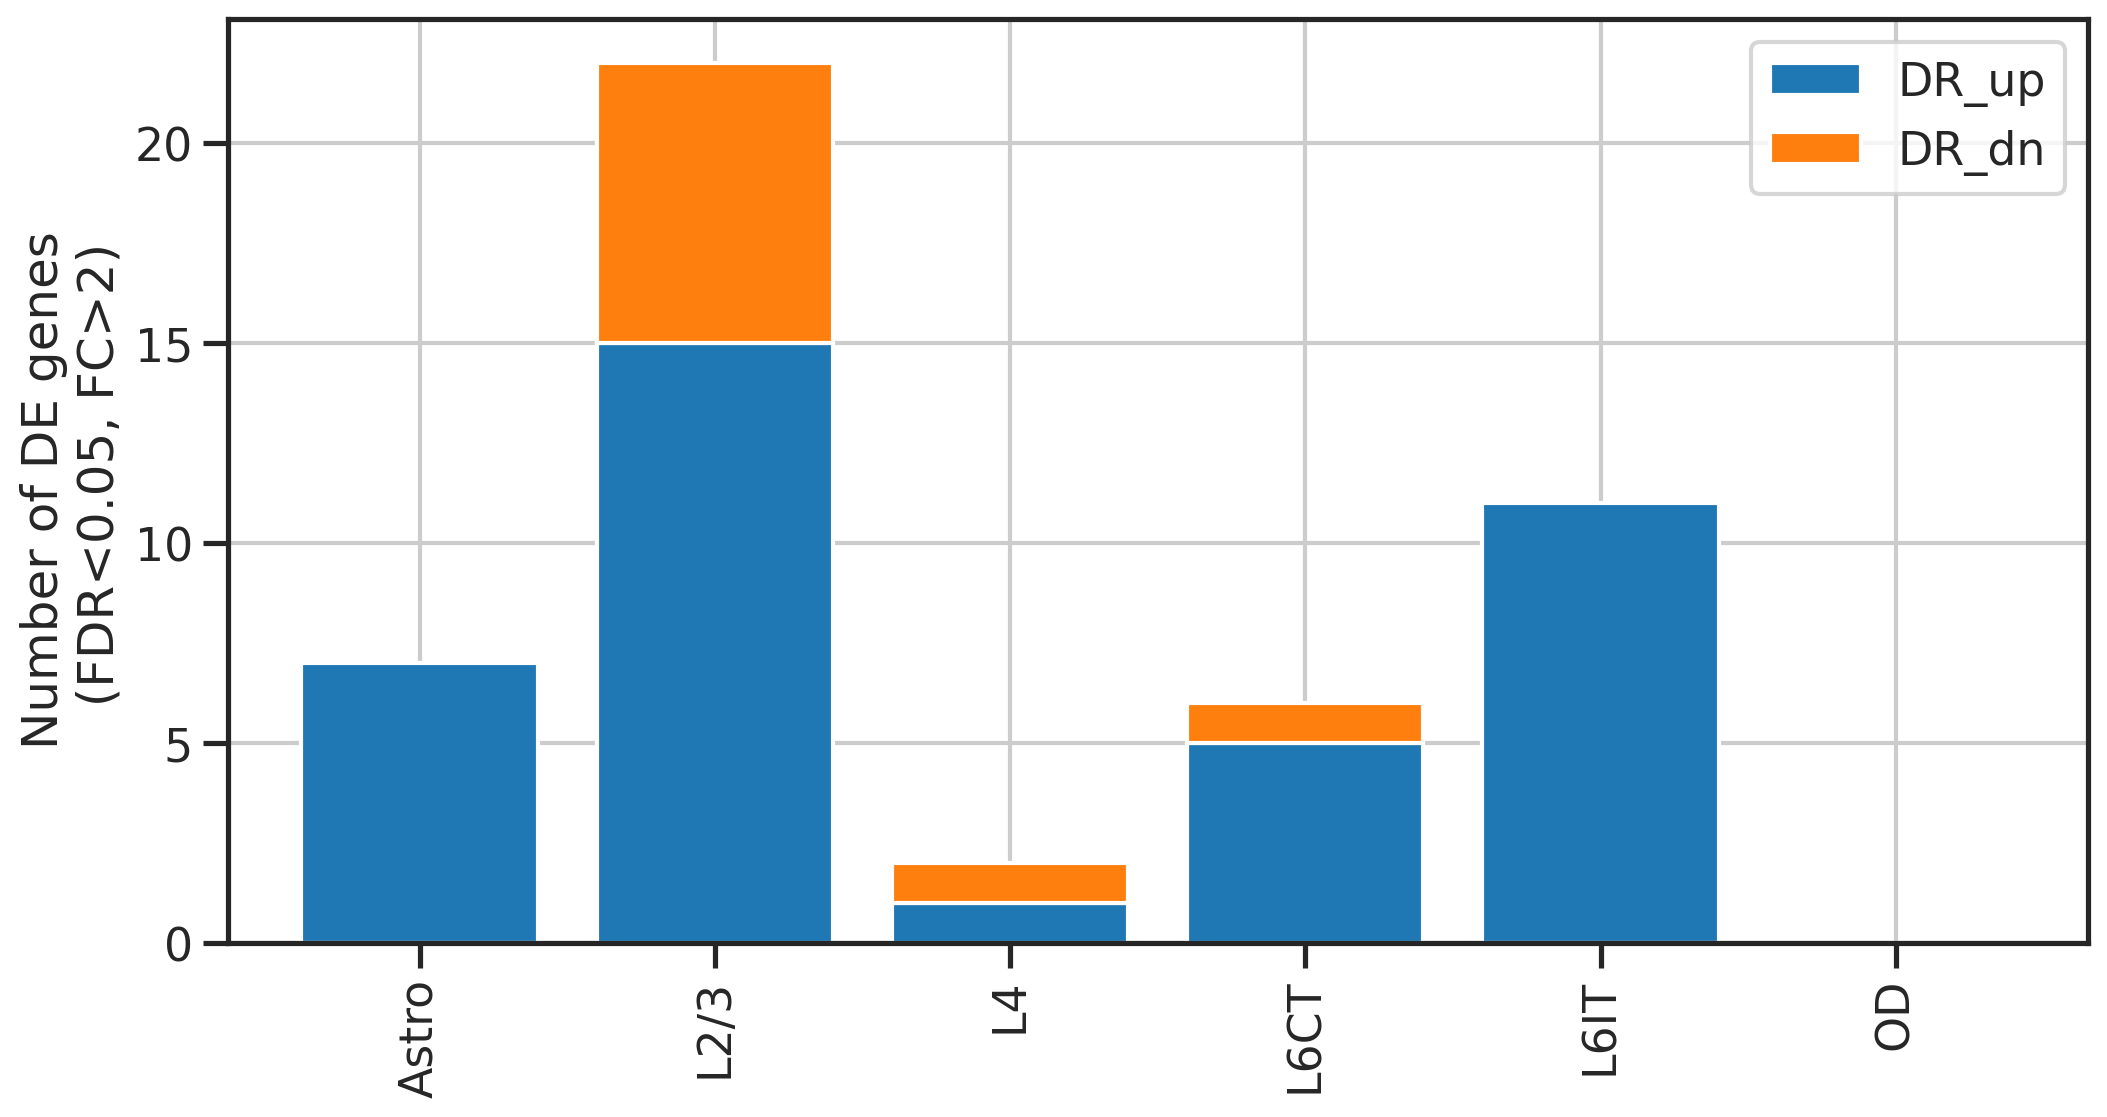

In [19]:
fig, ax = plt.subplots(figsize=(12,6))
# sigsum.loc[types_order][['DR_up', 'DR_dn']].plot.bar(stacked=True, width=0.8, ax=ax)
sigsum[['DR_up', 'DR_dn']].plot.bar(stacked=True, width=0.8, ax=ax)
ax.set_ylabel('Number of DE genes \n (FDR<0.05, FC>2)')
plt.show()